In [1]:
!pip install talos

You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
# https://colab.research.google.com/github/margaretmz/deep-learning/blob/master/fashion_mnist_keras.ipynb#scrollTo=aFe4wHGRFKle
# https://towardsdatascience.com/hyperparameter-optimization-with-keras-b82e6364ca53
from numpy.random import seed
seed(42)
from tensorflow import set_random_seed
set_random_seed(42)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import random
from tensorflow.python.framework import ops
from tensorflow.examples.tutorials.mnist import input_data
import talos as ta
random.seed(42)

/Users/Jostein/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# https://github.com/autonomio/talos/blob/master/examples/Hyperparameter%20Optimization%20on%20Keras%20with%20Breast%20Cancer%20Data.ipynb
import talos as ta
import wrangle as wr
from talos.metrics.keras_metrics import fmeasure_acc
from talos import live
from talos.model.early_stopper import early_stopper
from talos.model.normalizers import lr_normalizer


import pandas as pd

from keras.models import Sequential
from keras.layers import Dropout, Dense, Flatten, Conv2D, MaxPooling2D

# Keras items
from keras.optimizers import Adam, SGD, RMSprop
from keras.activations import relu, elu, softmax
from keras.losses import logcosh, categorical_crossentropy, sparse_categorical_crossentropy
from keras.callbacks import History 
from keras.callbacks import ModelCheckpoint
from keras.metrics import categorical_accuracy, sparse_categorical_accuracy
%matplotlib inline


In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [5]:
#x, y = tf.keras.datasets.fashion_mnist.load_data()

In [6]:
print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)

x_train shape: (60000, 28, 28) y_train shape: (60000,)


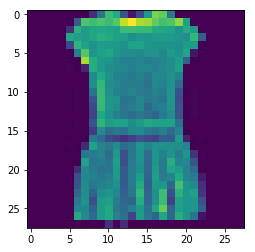

In [7]:
# Show one of the images from the training dataset
plt.imshow(x_train[3])

In [8]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [9]:
print("Number of train data - " + str(len(x_train)))
print("Number of test data - " + str(len(x_test)))

Number of train data - 60000
Number of test data - 10000


In [10]:
# Further break training data into train / validation sets (# put 5000 into validation set and keep remaining 55,000 for train)
(x_train, x_valid) = x_train[5000:], x_train[:5000] 
(y_train, y_valid) = y_train[5000:], y_train[:5000]

# Reshape input data from (28, 28) to (28, 28, 1)
w, h = 28, 28
x_train = x_train.reshape(x_train.shape[0], w, h, 1)
x_valid = x_valid.reshape(x_valid.shape[0], w, h, 1)
x_test = x_test.reshape(x_test.shape[0], w, h, 1)

# One-hot encode the labels
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_valid = tf.keras.utils.to_categorical(y_valid, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# Print training set shape
print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)

# Print the number of training, validation, and test datasets
print(x_train.shape[0], 'train set')
print(x_valid.shape[0], 'validation set')
print(x_test.shape[0], 'test set')

x_train shape: (55000, 28, 28, 1) y_train shape: (55000, 10)
55000 train set
5000 validation set
10000 test set


In [11]:
# https://towardsdatascience.com/hyperparameter-optimization-with-keras-b82e6364ca53
# first we have to make sure to input data and params into the function
def fashion_mnist_model(x_train, y_train, x_val, y_val, params):
    %%time
    model = Sequential()
    
    model.add(Conv2D(filters=params['first_neuron'], kernel_size=2, padding='same', activation=params['activation'], input_shape=(28,28,1))) 
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(params['dropout']))

    model.add(Conv2D(filters=params['first_neuron'], kernel_size=2, padding='same', activation=params['activation']))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(params['dropout']))

    model.add(Flatten())
    model.add(Dense(128, activation=params['activation']))
    model.add(Dropout(params['dropout']))
    model.add(Dense(10, activation=params['last_activation']))
    
    model.compile(loss=params['losses'],
                  optimizer=params['optimizer'](lr=lr_normalizer(params['lr'], params['optimizer'])),
                  metrics=['accuracy'])
    
    #checkpointer = ModelCheckpoint(filepath='model.weights.hdf5', verbose = 2, save_best_only=False)

    history = model.fit(x_train,
                        y_train, 
                        batch_size=params['batch_size'],
                        epochs=params['epochs'],
                        validation_data=[x_val, y_val],
                        callbacks=[live()])                        
                        #callbacks=[checkpointer])

    return history, model

# # Test run
p = {'lr': (0.1, 0.25, .50),
     'first_neuron': [64],
     'hidden_layers': [1],
     'batch_size': [32],
     'epochs': [1],
     'dropout': [0.25],
     'kernel_initializer': ['normal'],
     'weight_regulizer':[None],
     'emb_output_dims': [None],
     'optimizer': [Adam, SGD, RMSprop],
     'losses': [categorical_crossentropy],
     'activation':[relu],
     'last_activation': ['softmax']}

# Test run
%time
t = ta.Scan(x=x_train,
            y=y_train,
            model=fashion_mnist_model,
            grid_downsample=1, 
            params=p,
            dataset_name='fashion_mnist',
            experiment_no='2',
            seed=42,
            x_val=x_test,
            y_val=y_test
           )

In [ ]:
# ACTUAL PARAMETERS DO NOT DELETE
# then we can go ahead and set the parameter space
p = {'lr': (0.1, 0.25, 0.50, 0.75, 1.00),
     'first_neuron': [8, 16, 32, 64],
     'hidden_layers': [1],
     'batch_size': [8, 16, 32],
     'epochs': [5, 10, 15, 20],
     'dropout': [0.25, .50, .75],
     'kernel_initializer': ['normal'],
     'weight_regulizer':[None],
     'emb_output_dims': [None],
     'optimizer': [Adam, SGD, RMSprop],
     'losses': [categorical_crossentropy],
     'activation':[relu],
     'last_activation': ['softmax']}

In [ ]:
# ACTUAL SCAN DO NOT DELETE
# and run the experiment
%time
t = ta.Scan(x=x_train,
            y=y_train,
            model=fashion_mnist_model,
            grid_downsample=1.0, 
            params=p,
            dataset_name='fashion_mnist',
            experiment_no='1',
            seed=42,
            x_val=x_test,
            y_val=y_test
           )

In [69]:
# https://autonomio.github.io/docs_talos/#reporting
from talos import Reporting
r = Reporting('fashion_mnist_1.csv')
r.data

,round_epochs,val_loss,val_acc,loss,acc,lr,first_neuron,hidden_layers,batch_size,epochs,dropout,kernel_initializer,weight_regulizer,emb_output_dims,optimizer,losses,activation,last_activation
0,15,0.556822,0.7936,0.718916,0.728782,0.1,16,1,8,15,0.75,normal,None,None,<class 'keras.optimizers.Adam'>,<function categorical_crossentropy at 0x1c3156...,<function relu at 0x1c31596a60>,softmax
1,10,0.738696,0.7731,0.734979,0.738491,0.1,64,1,16,10,0.75,normal,None,None,<class 'keras.optimizers.RMSprop'>,<function categorical_crossentropy at 0x1c3156...,<function relu at 0x1c31596a60>,softmax
2,20,0.501580,0.8710,0.461132,0.841018,0.1,32,1,16,20,0.50,normal,None,None,<class 'keras.optimizers.RMSprop'>,<function categorical_crossentropy at 0x1c3156...,<function relu at 0x1c31596a60>,softmax
3,15,0.652057,0.7653,0.840567,0.685055,0.1,16,1,32,15,0.75,normal,None,None,<class 'keras.optimizers.Adam'>,<function categorical_crossentropy at 0x1c3156...,<function relu at 0x1c31596a60>,softmax
4,5,1.034115,0.6679,1.258599,0.536291,0.1,16,1,8,5,0.75,normal,None,None,<class 'keras.optimizers.SGD'>,<function categorical_crossentropy at 0x1c3156...,<function relu at 0x1c31596a60>,softmax


In [70]:
# returns the highest value for 'acc'
r.high('val_acc')

0.871

In [71]:
# returns the number of rounds it took to find best model
r.rounds2high('val_acc')

2

In [72]:
# returns the saved models (json)
t.saved_models

['{"class_name": "Sequential", "config": {"name": "sequential_1", "layers": [{"class_name": "Conv2D", "config": {"name": "conv2d_1", "trainable": true, "batch_input_shape": [null, 28, 28, 1], "dtype": "float32", "filters": 64, "kernel_size": [2, 2], "strides": [1, 1], "padding": "same", "data_format": "channels_last", "dilation_rate": [1, 1], "activation": "relu", "use_bias": true, "kernel_initializer": {"class_name": "VarianceScaling", "config": {"scale": 1.0, "mode": "fan_avg", "distribution": "uniform", "seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}}, {"class_name": "MaxPooling2D", "config": {"name": "max_pooling2d_1", "trainable": true, "pool_size": [2, 2], "padding": "valid", "strides": [2, 2], "data_format": "channels_last"}}, {"class_name": "Dropout", "config": {"name": "dropout_1", "trainable": true, "rate": 0.25, "n

In [73]:
# returns the saved model weights
t.saved_weights

[[array([[[[ 1.71661019e-01, -1.62655279e-01,  7.75171863e-03,
             1.48257062e-01,  1.53530389e-01, -2.50584874e-02,
            -3.07715274e-02, -1.71455994e-01,  1.25074238e-01,
             3.56306918e-02,  6.44317865e-02,  6.54846355e-02,
            -1.60652816e-01,  1.09174065e-01, -1.43346757e-01,
             1.60496995e-01,  1.04147987e-02,  8.55854675e-02,
            -5.52226184e-03,  2.09154971e-02, -6.90464079e-02,
             2.44592912e-02, -1.17323793e-01, -1.44272119e-01,
             1.55314699e-01,  4.14183475e-02, -1.03724986e-01,
            -1.37653828e-01, -3.76952589e-02, -1.87258065e-01,
            -1.06565960e-01,  1.33385271e-01, -1.90052927e-01,
            -1.46150514e-01,  1.27516940e-01,  1.11166663e-01,
            -1.41142651e-01, -1.04056746e-01,  8.68920535e-02,
            -3.01020630e-02,  1.25587225e-01,  7.59435445e-02,
            -1.28188834e-01, -1.63118303e-01,  1.21974744e-01,
            -5.68800196e-02,  1.77130565e-01,  1.540006

In [74]:
# returns the epoch entropy dataframe
t.peak_epochs_df

,val_loss,val_acc,loss,acc,acc_epoch,loss_epoch
1,0,0,0,0,0.0,0.0
2,0,0,0,0,0.0,0.0
3,0,0,0,0,0.0,0.0


In [75]:
# returns the results dataframe
t.data

,round_epochs,val_loss,val_acc,loss,acc,lr,first_neuron,hidden_layers,batch_size,epochs,dropout,kernel_initializer,weight_regulizer,emb_output_dims,optimizer,losses,activation,last_activation
1,1,0.5057177276134491,0.815,0.7735330810590224,0.7146181818095121,0.1,64,1,32,1,0.25,normal,None,None,<class 'keras.optimizers.Adam'>,<function categorical_crossentropy at 0x1c3156...,<function relu at 0x1c31596a60>,softmax
2,1,0.5171161607265472,0.8132,0.8008906350569291,0.7114181818181818,0.1,64,1,32,1,0.25,normal,None,None,<class 'keras.optimizers.RMSprop'>,<function categorical_crossentropy at 0x1c3156...,<function relu at 0x1c31596a60>,softmax
3,1,1.321253519630432,0.6033,1.93087986313213,0.33198181818181816,0.1,64,1,32,1,0.25,normal,None,None,<class 'keras.optimizers.SGD'>,<function categorical_crossentropy at 0x1c3156...,<function relu at 0x1c31596a60>,softmax


In [76]:
# returns the experiment configuration details
t.details

random_method            uniform_mersenne
reduction_method                     None
reduction_interval                     50
reduction_window                       20
grid_downsample                         1
reduction_threshold                   0.2
reduction_metric                  val_acc
reduce_loss                         False
experiment_name           fashion_mnist_2
complete_time              10/13/18/14:10
x_shape                (55000, 28, 28, 1)
y_shape                       (55000, 10)
dtype: object

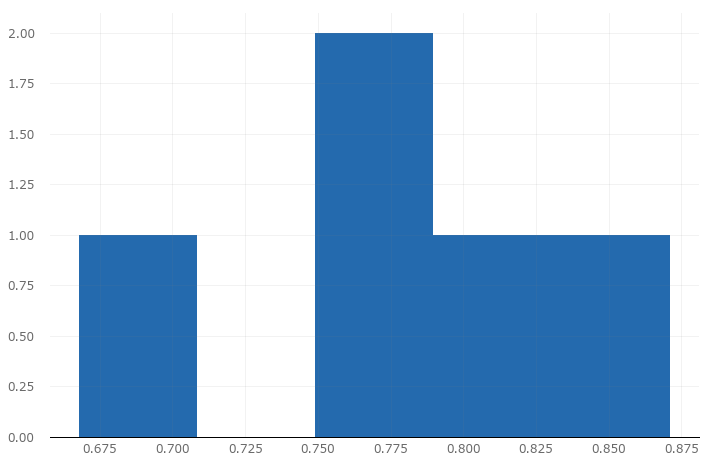

In [77]:
# A histogram for a given metric where each observation is a permutation
r.plot_hist('val_acc', bins=5)

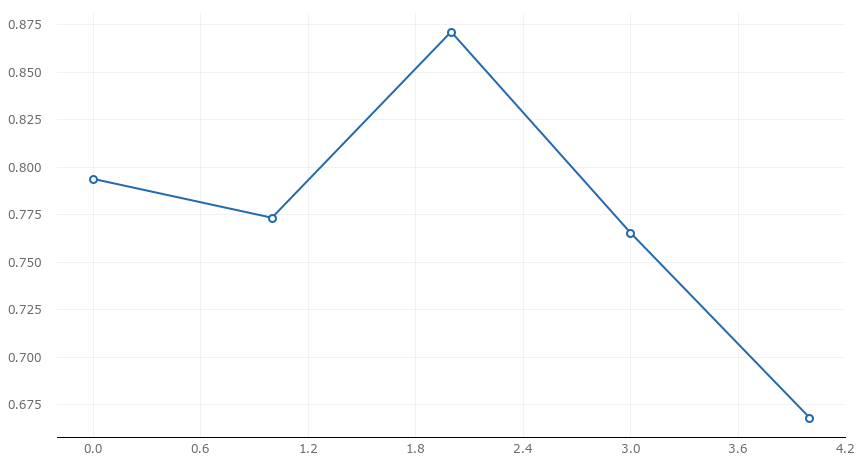

In [78]:
# A round-by-round line graph for a given metric
r.plot_line('val_acc')

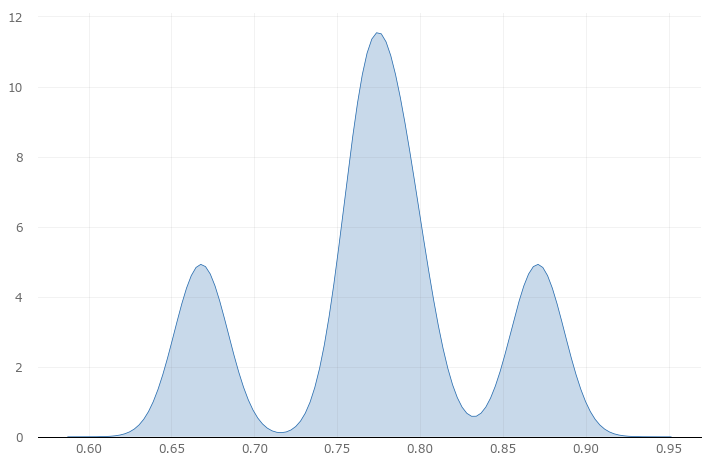

In [79]:
# up to two dimensional kernel density estimator
r.plot_kde('val_acc')

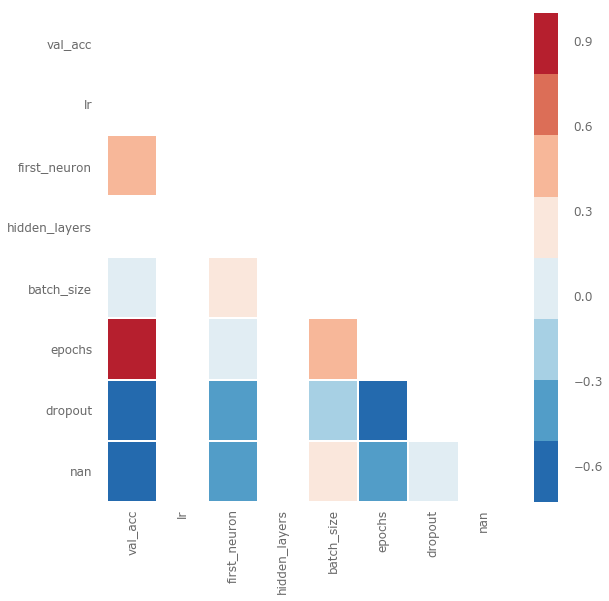

In [80]:
# A correlation heatmap where a single metric is compared against hyperparameters
r.plot_corr('val_acc')

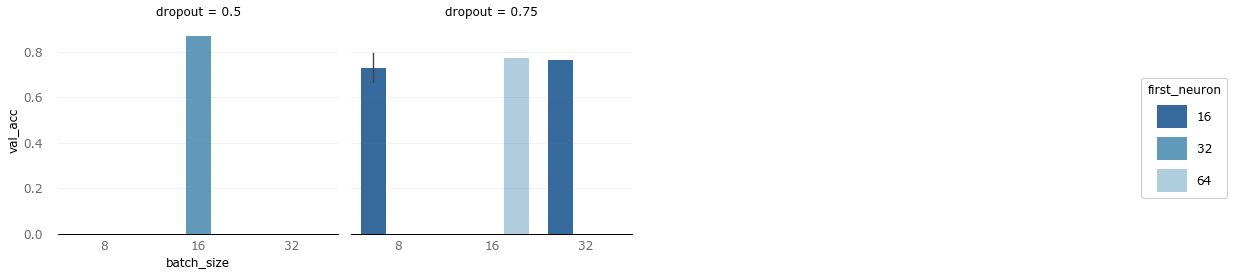

In [81]:
# a four dimensional bar grid
r.plot_bars('batch_size', 'val_acc', 'first_neuron', 'dropout')

In [33]:
#from talos import Predict, Evaluate
# https://autonomio.github.io/docs_talos/#predict
#p = Predict(t)
#r.best_model(metric='val_acc')
#r.predict(x_test)
#r.evaluate(x_test, y_test, folds=10, average='macro')

In [82]:
# https://autonomio.github.io/docs_talos/#evaluate
from talos import Predict, Evaluate
e = Evaluate(t)
e.evaluate(x_test, y_test, average='macro', metric='val_acc')

77.69% (+/- 0.20%)


In [86]:
t.x.shape

(55000, 28, 28, 1)

In [87]:
t.x.shape[0]

55000

In [89]:
t.y.shape

(55000, 10)

In [91]:
t.x.shape[1]

28

In [92]:
t.x.shape[2]

28

In [54]:
#w, h = 28, 28
#x_train = x_train.reshape(x_train.shape[0], w, h, 1)
#t.x = t.x.reshape(t.x.shape[0], w, h)

In [93]:
#https://stackoverflow.com/questions/32838802/numpy-with-python-convert-3d-array-to-2d
w, h = 28, 28
#t.x = t.x.reshape(t.x.shape[0], w*h)
t.x = t.x.reshape(t.x.shape[0], t.x.shape[1]*t.x.shape[2])
t.x = t.x.transpose()
t.x.shape

(784, 55000)

In [94]:
from talos import Deploy
ta.Deploy(t, 'capstone', metric='val_acc');

Deploy package capstone have been saved.


In [97]:
from talos import Restore
restored_model = Restore('capstone.zip')

In [106]:
restored_model.model.predict(x_test)

array([[1.93016720e-04, 1.08381035e-04, 2.25291922e-04, ...,
        1.65288404e-01, 5.17041516e-03, 7.94769406e-01],
       [1.90062763e-03, 1.00327154e-04, 9.20545816e-01, ...,
        2.55850446e-05, 3.45837820e-04, 8.60867847e-04],
       [9.99696204e-06, 9.99771178e-01, 5.78586082e-07, ...,
        3.98366581e-07, 3.41423925e-06, 2.26941310e-07],
       ...,
       [9.10926834e-02, 8.84870024e-05, 1.72936334e-03, ...,
        7.25320820e-03, 6.72087073e-01, 3.19104933e-04],
       [1.78436167e-04, 9.65032399e-01, 1.62802917e-05, ...,
        2.72768430e-05, 7.20732860e-05, 5.68181676e-05],
       [3.62706208e-03, 9.99029493e-04, 8.87268595e-03, ...,
        2.50182986e-01, 3.41129266e-02, 3.22266854e-02]], dtype=float32)

In [98]:
restored_model.details

,0,1
0,random_method,uniform_mersenne
1,reduction_method,NaN
2,reduction_interval,50
3,reduction_window,20
4,grid_downsample,1
5,reduction_threshold,0.2
6,reduction_metric,val_acc
7,reduce_loss,False
8,experiment_name,fashion_mnist_2
9,complete_time,10/13/18/14:10


In [99]:
restored_model.params

{'lr': (0.1, 0.25, 0.5),
 'first_neuron': [64],
 'hidden_layers': [1],
 'batch_size': [32],
 'epochs': [1],
 'dropout': [0.25],
 'kernel_initializer': ['normal'],
 'weight_regulizer': [None],
 'emb_output_dims': [None],
 'optimizer': [keras.optimizers.Adam,
  keras.optimizers.SGD,
  keras.optimizers.RMSprop],
 'losses': [<function keras.losses.categorical_crossentropy(y_true, y_pred)>],
 'activation': [<function keras.activations.relu(x, alpha=0.0, max_value=None, threshold=0.0)>],
 'last_activation': ['softmax']}

In [100]:
restored_model.results

,round_epochs,val_loss,val_acc,loss,acc,lr,first_neuron,hidden_layers,batch_size,epochs,dropout,kernel_initializer,weight_regulizer,emb_output_dims,optimizer,losses,activation,last_activation
0,1,0.505718,0.8150,0.773533,0.714618,0.1,64,1,32,1,0.25,normal,None,None,<class 'keras.optimizers.Adam'>,<function categorical_crossentropy at 0x1c3156...,<function relu at 0x1c31596a60>,softmax
1,1,0.517116,0.8132,0.800891,0.711418,0.1,64,1,32,1,0.25,normal,None,None,<class 'keras.optimizers.RMSprop'>,<function categorical_crossentropy at 0x1c3156...,<function relu at 0x1c31596a60>,softmax
2,1,1.321254,0.6033,1.930880,0.331982,0.1,64,1,32,1,0.25,normal,None,None,<class 'keras.optimizers.SGD'>,<function categorical_crossentropy at 0x1c3156...,<function relu at 0x1c31596a60>,softmax


In [101]:
restored_model.x

,0,1,2,3,4,5,6,7,8,9,...,54990,54991,54992,54993,54994,54995,54996,54997,54998,54999
0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
1,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
2,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
3,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
4,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
5,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
6,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
7,0.000000,0.172549,0.0,0.0,0.0,0.0,0.000000,0.003922,0.000000,0.003922,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
8,0.000000,0.215686,0.0,0.0,0.0,0.0,0.003922,0.003922,0.000000,0.000000,...,0.003922,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
9,0.000000,0.376471,0.0,0.0,0.0,0.0,0.003922,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.019608,0.000000,0.0


In [102]:
restored_model.y

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
